In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [61]:
####### ODES ######
def ode_rho_m(t, y: tuple, r, l, pi):
    rho, m = y
    drho_dt = (1-rho)*(2*pi + l/2*(rho**2+m**2)) - r*rho
    dm_dt = l*(1-rho)*rho*m - r*m
    return drho_dt, dm_dt

def fs_evo_eq(t,fs,r,l,pi):
    dfsdt = [0.0,]
    for i in range(len(fs)-1):
        site_i = i+1
        dfdt = fs[0]*(pi+l*fs[site_i]**2) - r*fs[site_i]
        dfsdt.append(dfdt)
    dfsdt[0] = -1*sum(dfsdt[1:])
    return dfsdt
####################

def poly3_rho_param_m(rho, r,l,pi,m):
    a, b = 1, -1
    c = 2*r/l + m**2
    d = -4*pi - m**2
    return a*rho**3 + b*rho**2 + c*rho + d

def poly3_rho_param_m_sols(r, l, pi, m):
    a, b = 1, -1
    c = 2*r/l + m**2
    d = -4*pi - m**2
    # step 1: delta0 and elta 1
    delta0 = b**2 - 3*a*c
    delta1 = 2*b**3 - 9*a*b*c + 27*a**2*d
    # step 2: computation of C:
    if delta0 == 0.0 and delta1 != 0.0:
        C = delta1**(1/3) # cubic_root[(delta1 + sqrt(delta1**2+0))/2]
    elif delta0 == 0.0 and delta1 == 0.0:
        C = 1.0 # so in the next step delta0/C yields 0.0 instead of NaN (0.0/0.0)
    else:
        radicand0 = delta1**2 - 4*delta0**3
        if radicand0 < 0:
            root0 = complex(0,np.sqrt(-1*radicand0))
        else:
            root0 = complex(np.sqrt(radicand0),0)
        radicand1 = (delta1 + root0)/2
        C = radicand1**(1/3)
    # 3: Final solution
    ksi = complex(-1, np.sqrt(3))/2
    roots, roots_Re = [], []
    for k in range(3):
        f0_root = -1/(3*a)*(b + ksi**k*C + delta0/(C*ksi**k))
        roots.append(f0_root), roots_Re.append(f0_root.real)
    return roots_Re, roots


# when m=0, this is the poly we have to solve for rho:
def poly3_rho_m0(rho, r, l, pi):
    a, b = -l/2, l/2
    c = -2*pi - 1
    d = 2*pi
    return a*rho**3 + b*rho**2 + c*rho + d

def poly3_rho_m0_sols(r, l, pi):
    a, b = -l/2, l/2
    c = -2*pi - 1
    d = 2*pi
    # step 1: delta0 and elta 1
    delta0 = b**2 - 3*a*c
    delta1 = 2*b**3 - 9*a*b*c + 27*a**2*d
    # step 2: computation of C:
    if delta0 == 0.0 and delta1 != 0.0:
        C = delta1**(1/3) # cubic_root[(delta1 + sqrt(delta1**2+0))/2]
    elif delta0 == 0.0 and delta1 == 0.0:
        C = 1.0 # so in the next step delta0/C yields 0.0 instead of NaN (0.0/0.0)
    else:
        radicand0 = delta1**2 - 4*delta0**3
        if radicand0 < 0:
            root0 = complex(0,np.sqrt(-1*radicand0))
        else:
            root0 = complex(np.sqrt(radicand0),0)
        radicand1 = (delta1 + root0)/2
        C = radicand1**(1/3)
    # 3: Final solution
    ksi = complex(-1, np.sqrt(3))/2
    roots, roots_Re = [], []
    for k in range(3):
        f0_root = -1/(3*a)*(b + ksi**k*C + delta0/(C*ksi**k))
        roots.append(f0_root), roots_Re.append(f0_root.real)
    return roots_Re, roots


####### LSA #######
def LSA_matrix(sol, r, l, pi):
    # sol = (rho, m)
    rho, m = sol
    a11 = (1-rho)*rho*l - 2*pi - l/2*(rho**2 + m**2) - r
    a12 = (1-rho)*m*l
    a21 = 0
    a22 = l*(1-rho)*rho - r
    return np.array([[a11, a12], [a21, a22]])

def LSA_matrix_fs(falphas, r, l, pi):
    # falphas do not contain f0!!!
    mat = []
    f0 = 1 - sum(falphas)
    for i in range(len(falphas)):
        row = []
        for j in range(len(falphas)):
            if i == j:
                row.append( 2*l*f0*falphas[i] - r - pi - l*falphas[i] )
            else:
                row.append( -pi-l*falphas[i]**2 )
        mat.append(row)
    return np.array(mat)


In [30]:
r, l = 0.1, 1
pi = 0.0
m = 0.5
solsRe, solsC = poly3_rho_param_m_sols(r, l, pi, 0.25)

for sol in solsC:
    if abs(sol.imag) < 1e-8:
        rho = sol.real
        print(f'm = {m}, rho = {rho}')
        valODEs = ode_rho_m((rho, m), r, l, pi)
        print(f'dot_m = {valODEs[1]}, dot_rho = {valODEs[0]}')

m = 0.5, rho = 0.7633858350930371
dot_m = 0.040313950936171725, dot_rho = 0.022182577960027663


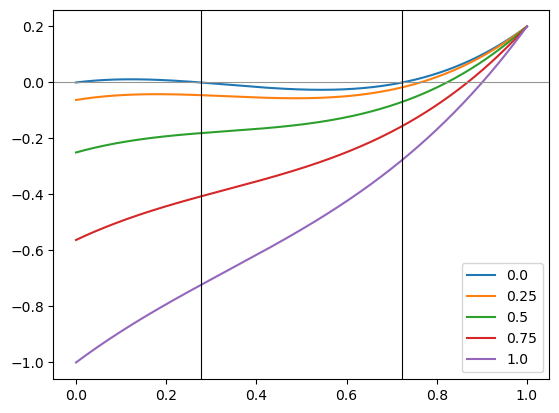

In [32]:
rhos = np.arange(0.0, 1.001, 0.001)
r, l = 0.1, 1
pi = 0.0

fig, ax = plt.subplots()
for m in [0.0, 0.25, 0.5, 0.75, 1.0]:
    polyVals = poly3_rho_param_m(rhos, r,l,pi, m)
    ax.plot(rhos, polyVals, label=m)
ax.legend()
ax.axhline(0.0, lw=0.8, color='xkcd:gray')

# sol when pi=0 and and m=0
rho = (1+np.sqrt(1-8*r/l))/2
ax.axvline(rho, lw=0.8, color='xkcd:black')
rho = (1-np.sqrt(1-8*r/l))/2
ax.axvline(rho, lw=0.8, color='xkcd:black')

In [38]:
pi = 0
r, l = 0.1, 1

rho, m = (1+np.sqrt(1-8*r/l))/2, 0
# rho, m = (1-np.sqrt(1-8*r/l))/2, 0
# rho, m = 0, 0

# one species solutions brought here
# rho = (1+np.sqrt(1-4*r/l))/2
# rho = (1-np.sqrt(1-4*r/l))/2
# m = rho # or -rho


valODEs = ode_rho_m(0, (rho, m), r, l, pi)
print(f'dot_m = {valODEs[1]}, dot_rho = {valODEs[0]}')

# LSA:
lsa_mat = LSA_matrix((rho, m), r, l, pi)
eigvals = np.linalg.eig(lsa_mat)[0]
print(eigvals)

# f1, f2 = rho, 0
# f1, f2 = 0, rho
f1, f2 = rho/2, rho/2
valODEs = fs_evo_eq(0, (1-f1-f2, f1, f2), r, l, pi)
print(f'dot_f0 = {valODEs[0]}, dot_f1 = {valODEs[1]}, dot_f2 = {valODEs[2]}')
lsa_mat_fs = LSA_matrix_fs((f1, f2), r, l, pi)
eigvals = np.linalg.eig(lsa_mat_fs)[0]
print(eigvals)

dot_m = 0.0, dot_rho = 0.0
[-0.1618034  0.1      ]
dot_f0 = -0.0, dot_f1 = 0.0, dot_f2 = 0.0
[-0.1309017 -0.3927051]


In [40]:
pi, r, l = 1.0, 0.1, 6.5
rho_m_t0 = [0.5, 0.1]
sol = solve_ivp(ode_rho_m, [0, 2000], rho_m_t0, args=(r, l, pi))

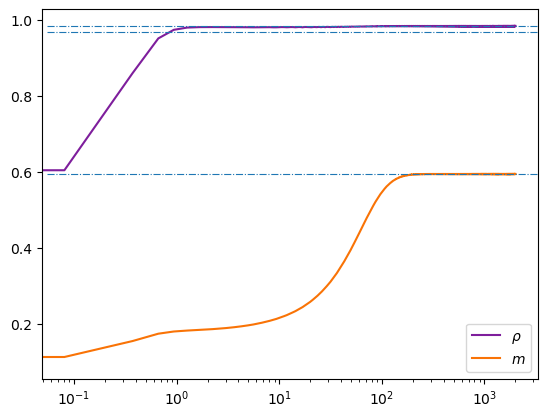

In [49]:
fig, ax = plt.subplots()

ax.plot(sol.t, sol.y[0], color='xkcd:purple', label=r'$\rho$')
ax.plot(sol.t, sol.y[1], color='xkcd:orange', label=r'$m$')

# lines for rho
rho_1op = (1+np.sqrt(1-4*r/l))/2
rho_2op = (1+np.sqrt(1-8*r/l))/2
ax.axhline(rho_1op, xmin=0.01, xmax=sol.t[-1], lw=0.8, ls='-.')
ax.axhline(rho_2op, xmin=0.01, xmax=sol.t[-1], lw=0.8, ls='-.')

# lines for m
m = np.sqrt(rho_1op**2 - 4*pi/l)
ax.axhline(m, xmin=0.01, xmax=sol.t[-1], lw=0.8, ls='-.')

ax.legend()
ax.set_xscale('log')

In [3]:
r, l, pi = 0.1, 1, 0.0
r, l, pi = 0.2, 1, 0.0

fs0 = [0.0,0.6,0.4] # goes to the single species stationary point
fs0 = [0.0, 0.51, 0.49] # same

# fs0 = [0.0, 0.5, 0.5] # goes to the 2 species stationary point but with the active population equiditributed between the two sites

# rho = (1+np.sqrt(1-8*r/l))/2
# fs0 = [1-rho, rho, 0.0]

# one option solution:
rho_single_species = (1+np.sqrt(1-4*r/l))/2
fs0 = [1-rho_single_species, rho_single_species, 0.0]

sol = solve_ivp(fs_evo_eq, [0,2000], fs0, args=(r, l, pi))

In [ ]:
fig, ax = plt.subplots()
ax.set(xscale='symlog')
ax.plot(sol.t, sol.y[0], color='xkcd:red')
ax.plot(sol.t, sol.y[1], color='xkcd:green')
ax.plot(sol.t, sol.y[2], color='xkcd:blue')

rho = (1+np.sqrt(1-8*r/l))/2
rho_single_species = (1+np.sqrt(1-4*r/l))/2

ax.axhline(rho, 0, 1, color='xkcd:mauve', lw=0.8, ls='-.')
ax.axhline(rho_single_species, 0, 1, color='xkcd:dark purple', lw=0.8, ls='-.')

f0 = 1 - rho
f0_single_species = 1 - rho_single_species
ax.axhline(f0, 0, 1, color='xkcd:mauve', lw=0.8, ls='-.')
ax.axhline(f0_single_species, 0, 1, color='xkcd:dark purple', lw=0.8, ls='-.')

# rho_equi = rho/2
# ax.axhline(rho_equi, 0, 1, color='xkcd:gray', lw=0.8, ls='-.')

/tmp/ipykernel_254287/52363.py:7: RuntimeWarning: invalid value encountered in sqrt
  rho = (1+np.sqrt(1-8*r/l))/2


# Pi > 0

In [39]:
r, pi = 1, 1.0
# Valid lambdas for m solution given pi:
lm = (4*pi + 1)**2/(4*pi)

print(lm)

6.25


In [55]:
ls = np.arange(1,8,0.1)
r, pi = 1, 0.1

rho_m_t0 = [0.5, 0.1]
rho_m_int_pi_large = [[], []]
rho_m_int_pi_small = [[], []]

for l in ls:
    # integrate equations:
    pi = 1
    sol = solve_ivp(ode_rho_m, [0, 2000], rho_m_t0, args=(r, l, pi))
    rho_m_int_pi_large[0].append(sol.y[0][-1]), rho_m_int_pi_large[1].append(sol.y[1][-1])
    pi = 0.1
    sol = solve_ivp(ode_rho_m, [0, 2000], rho_m_t0, args=(r, l, pi))
    rho_m_int_pi_small[0].append(sol.y[0][-1]), rho_m_int_pi_small[1].append(sol.y[1][-1])

/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/3555075681.py:16: RuntimeWarning: invalid value encountered in sqrt
  rho_theo = [(1+np.sqrt(1-4*r/l))/2 for l in ls]
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/3555075681.py:23: RuntimeWarning: invalid value encountered in sqrt
  rho_theo = [(1+np.sqrt(1-4*r/l))/2 for l in ls]
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/3555075681.py:24: RuntimeWarning: invalid value encountered in sqrt
  mtheo = [np.sqrt(rho**2 - 4*pi/l) for rho,l in zip(rho_theo, ls)]


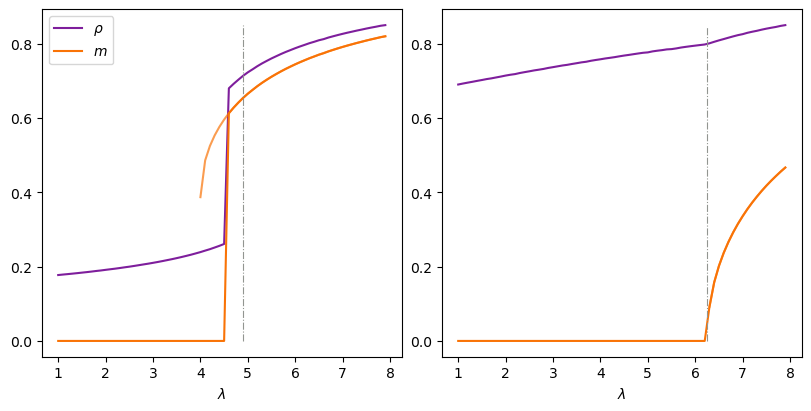

In [60]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(8,4))
ax[0].set(xlabel='$\lambda$')
ax[1].set(xlabel='$\lambda$')

ax[0].plot(ls, rho_m_int_pi_small[0], label=r'$\rho$', color='xkcd:purple')
ax[0].plot(ls, rho_m_int_pi_small[1], label=r'$m$', color='xkcd:orange')
ax[0].legend()

ax[1].plot(ls, rho_m_int_pi_large[0], label=r'$\rho$', color='xkcd:purple')
ax[1].plot(ls, rho_m_int_pi_large[1], label=r'$m$', color='xkcd:orange')

# theoretical solutions and thresholds:

pi = 0.1
lm = (4*pi + 1)**2/(4*pi)
rho_theo = [(1+np.sqrt(1-4*r/l))/2 for l in ls]
mtheo = [np.sqrt(rho**2 - 4*pi/l) for rho,l in zip(rho_theo, ls)]
ax[0].plot(ls, mtheo, color='xkcd:orange', alpha=0.7)
ax[0].vlines(lm, 0.0, 0.85, lw=0.8, ls='-.', color='xkcd:gray')

pi = 1
lm = (4*pi + 1)**2/(4*pi)
rho_theo = [(1+np.sqrt(1-4*r/l))/2 for l in ls]
mtheo = [np.sqrt(rho**2 - 4*pi/l) for rho,l in zip(rho_theo, ls)]
ax[1].plot(ls, mtheo, color='xkcd:orange', alpha=0.7)
ax[1].vlines(lm, 0.0, 0.85, lw=0.8, ls='-.', color='xkcd:gray')

In [105]:
# poly3_rho_m0_sols(1, 6.6, 0.05)
solsRe, solsIM = poly3_rho_m0_sols(r, 6.6, pi)

In [106]:
# print(r, l, pi)
solsRe

[0.4277527224904509, 0.14449455501909847, 0.42775272249045077]

# Theoretical Solutions pi>0

In [84]:
ls = np.arange(1,8,0.02)
r = 1

rho_m_plus_pi_small = [[], []]
rho_m_plus_pi_large = [[], []]
rho_m_minus_pi_small = [[], []]
rho_m_minus_pi_large = [[], []]

mps, mms = [], []

pi = 0.05
for l in ls:
    rhop, rhom = (1+np.sqrt(1-4*r/l))/2, (1-np.sqrt(1-4*r/l))/2
    mp, mm = np.sqrt(rhop**2 - 4*pi/l), np.sqrt(rhom**2 - 4*pi/l)
    rho_m_plus_pi_small[0].append(rhop), rho_m_plus_pi_small[1].append(mp)
    rho_m_minus_pi_small[0].append(rhom), rho_m_minus_pi_small[1].append(mm)

pi = 1.0
for l in ls:
    rhop, rhom = (1+np.sqrt(1-4*r/l))/2, (1-np.sqrt(1-4*r/l))/2
    mp, mm = np.sqrt(rhop**2 - 4*pi/l), np.sqrt(rhom**2 - 4*pi/l)
    rho_m_plus_pi_large[0].append(rhop), rho_m_plus_pi_large[1].append(mp)
    rho_m_minus_pi_large[0].append(rhom), rho_m_minus_pi_large[1].append(mm)

/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/845360445.py:12: RuntimeWarning: invalid value encountered in sqrt
  rhop, rhom = (1+np.sqrt(1-4*r/l))/2, (1-np.sqrt(1-4*r/l))/2
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/845360445.py:13: RuntimeWarning: invalid value encountered in sqrt
  mp, mm = np.sqrt(rhop**2 - 4*pi/l), np.sqrt(rhom**2 - 4*pi/l)
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/845360445.py:19: RuntimeWarning: invalid value encountered in sqrt
  rhop, rhom = (1+np.sqrt(1-4*r/l))/2, (1-np.sqrt(1-4*r/l))/2
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_28218/845360445.py:20: RuntimeWarning: invalid value encountered in sqrt
  mp, mm = np.sqrt(rhop**2 - 4*pi/l), np.sqrt(rhom**2 - 4*pi/l)


In [116]:
rho_m0_pi_small = [[], []]
rho_m0_pi_large = [[], []]

r = 1
pi = 0.05
ls_m0 = np.arange(1,6,0.1)
ls_m0 = np.around(ls_m0, 8)
for l in ls_m0:
    solsRe, solsIM = poly3_rho_m0_sols(r, l, pi)
    real_parts = []
    for sol in solsIM:
        if abs(sol.imag) < 1e-8:
            real_parts.append(sol)
    if len(real_parts) > 1:
        print(round(l,8), pi)
        print(solsIM)
    if len(real_parts) == 0:
        print(round(l,8), pi)
        print(solsIM)
    rho_m0_pi_small[0].append(real_parts[0])
    rho_m0_pi_small[1].append(0.0)

pi = 1.0
for l in ls_m0:
    solsRe, solsIM = poly3_rho_m0_sols(r, l, pi)
    real_parts = []
    for sol in solsIM:
        if abs(sol.imag) < 1e-8:
            real_parts.append(sol)
    if len(real_parts) > 1:
        print(l, pi)
        print(solsIM)
    if len(real_parts) == 0:
        print(l, pi)
        print(solsIM)
    rho_m0_pi_large[0].append(real_parts[0])
    rho_m0_pi_large[1].append(0.0)

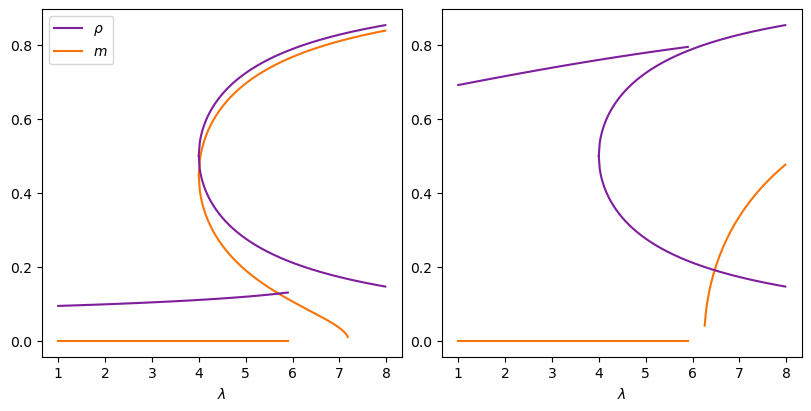

In [118]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(8,4))
ax[0].set(xlabel='$\lambda$')
ax[1].set(xlabel='$\lambda$')

ax[0].plot(ls, rho_m_plus_pi_small[0], label=r'$\rho$', color='xkcd:purple')
ax[0].plot(ls, rho_m_plus_pi_small[1], label=r'$m$', color='xkcd:orange')

ax[0].plot(ls, rho_m_minus_pi_small[0], color='xkcd:purple')
ax[0].plot(ls, rho_m_minus_pi_small[1], color='xkcd:orange')

ax[0].plot(ls_m0, rho_m0_pi_small[0], color='xkcd:purple')
ax[0].plot(ls_m0, rho_m0_pi_small[1], color='xkcd:orange')
ax[0].legend()

ax[1].plot(ls, rho_m_plus_pi_large[0], label=r'$\rho$', color='xkcd:purple')
ax[1].plot(ls, rho_m_plus_pi_large[1], label=r'$m$', color='xkcd:orange')

ax[1].plot(ls, rho_m_minus_pi_large[0], color='xkcd:purple')
ax[1].plot(ls, rho_m_minus_pi_large[1], color='xkcd:orange')

ax[1].plot(ls_m0, rho_m0_pi_large[0], color='xkcd:purple')
ax[1].plot(ls_m0, rho_m0_pi_large[1], color='xkcd:orange')

# ax.plot(ls, mps)
# ax.plot(ls, mms)
# ax.vlines((4*pi+1)**2/(4*pi), 0, 1, lw=0.8, ls='-.', color='xkcd:gray')